## Studying modern NBA roles using neural nets
This notebook contains the analysis of statistics of NBA players from the 2016-17 year using mathematical models, focusing on a subset of neural nets known as autoencoders. As the playstyle of the NBA changes, players find different roles to fill on their teams, assuming more or less responsibility. As a result, traditional positions don't accurately explain what a players skillset truly is, and as such, different methods of analyzing a player's strengths and weaknesses are necessary. 

To do so, I will be looking at 3 different views of the 2016-17 data - advanced metrics, per possession metrics, and per-36 minutes metrics. I will then look at how the data is encoded under the various models, and look at the most similar players to some representative players, based on Euclidean distance. To evaluate, I'll judge how well the similar player lists summarize the representative player.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os
import torch, torchvision

from autoencoder import AutoEncoder
from multilayer_autoencoder import MultilayerAutoEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from vae import VAE

### Preprocessing
All data is obtained from basketball-reference.com, an open source repository of statistics for basketball. I will be using the 2016-2017 statistics as an experiment.

In [2]:
files = ["advanced_stats.csv", "per_poss_stats.csv", "per_36_stats.csv"]
player_id = {}
id_player = {}
team_id = {}
id_team = {}
pos_id = {}
id_pos = {}
for file in files:
    output = []
    with open(file, "r") as f:
        lines = f.readlines()[1:]
        names = [l.strip().split(",")[1] for l in lines]
        names = [name.strip().split("\\")[0] for name in names]
        positions = [l.strip().split(",")[2] for l in lines]
        teams = [l.strip().split(",")[4] for l in lines]
        for name in names:
            if name not in player_id:
                id = len(player_id)
                player_id[name] = id
                id_player[id] = name
        for position in positions:
            if position not in pos_id:
                id = len(pos_id)
                pos_id[position] = id
                id_pos[id] = position
        for team in teams:
            if team not in team_id:
                id = len(team_id)
                team_id[team] = id
                id_team[id] = team

In [3]:
def process_files(player_id, team_id, pos_id):
    files = ["advanced_stats.csv", "per_poss_stats.csv", "per_36_stats.csv"]
    headers = ["Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,"
               "STL%,BLK%,TOV%,USG%,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP",
               "Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,"
               "FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,,ORtg,DRtg",
               "Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,"
               "FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS"]
    headers = [h.strip().split(",") for h in headers]
    for file, header in zip(files, headers):
        deleted = []
        with open(file, "r") as f:
            lines = f.readlines()
            out_lines = [','.join([h for h in header if h != ''])]
            for index, l in enumerate(lines[1:]):
                line = l.strip().split(",")
                flag = True
                out_line = []
                for i, s in enumerate(line):
                    if (s == '' and header[i] != ''): flag = False

                    if i == 1: out_line.append(str(player_id[s.strip().split("\\")[0]]))
                    elif i == 2: out_line.append(str(pos_id[s]))
                    elif i == 4: out_line.append(str(team_id[s]))
                    elif (s == '' and header[i] == ''): continue
                    else: out_line.append(s)
                if (flag): out_lines.append(",".join(out_line))
                else: deleted.append(index + 1)
            with open(os.path.join("processed", file), "w") as f:
                print("\n".join(out_lines), file = f)
process_files(player_id, team_id, pos_id)

Ignoring the rank of a player on the list and their position is important, as these two are figures which won't contribute to measuring their playstyle.

In [4]:
pre_advanced_stats = np.genfromtxt("processed/advanced_stats.csv", delimiter = ",",
                                   skip_header = 1, dtype = float)[:, 1:]
pre_per_poss_stats = np.genfromtxt("processed/per_poss_stats.csv", delimiter = ",",
                                   skip_header = 1, dtype = float)[:, 1:]
pre_per_36_stats = np.genfromtxt("processed/per_36_stats.csv", delimiter = ",",
                                 skip_header = 1, dtype = float)[:, 1:]

advanced_ids = pre_advanced_stats[:, 0]
advanced_stats = pre_advanced_stats[:, 2:]

per_poss_ids = pre_per_poss_stats[:, 0]
per_poss_stats = pre_per_poss_stats[:, 2:]

per_36_ids = pre_per_36_stats[:, 0]
per_36_stats = pre_per_36_stats[:, 2:]

for a, b in zip(per_poss_ids, per_36_ids): assert(a == b)

In [5]:
print(advanced_stats.shape)
print(per_poss_stats.shape)
print(per_36_stats.shape)

(485, 24)
(439, 28)
(439, 26)


In [6]:
headers = ["Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,"
           "STL%,BLK%,TOV%,USG%,,OWS,DWS,WS,WS/48,,OBPM,DBPM,BPM,VORP",
           "Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,"
           "FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,,ORtg,DRtg",
           "Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,"
           "FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS"]
info_headers = [h.strip().split(",")[2:] for h in headers]
advanced_info, per_poss_info, per_36_info = info_headers

In [7]:
player_info = {}
for index, row in enumerate(advanced_stats):
    id = int(advanced_ids[index])
    name = id_player[id]
    if name not in player_info:
        player_info[name] = {'advanced': {}, 'per_poss': {}, 'per_36': {}}
    player_info[name]['advanced']['index'] = index
    for i, val in enumerate(row): player_info[name]['advanced'][advanced_info[i]] = val
for index, row in enumerate(per_poss_stats):
    id = int(per_poss_ids[index])
    name = id_player[id]
    if name not in player_info:
        player_info[name] = {'advanced': {}, 'per_poss': {}, 'per_36': {}}
    player_info[name]['per_poss']['index'] = index
    for i, val in enumerate(row): player_info[name]['per_poss'][per_poss_info[i]] = val
for index, row in enumerate(per_36_stats):
    id = int(per_36_ids[index])
    name = id_player[id]
    if name not in player_info:
        player_info[name] = {'advanced': {}, 'per_poss': {}, 'per_36': {}}
    player_info[name]['per_36']['index'] = index
    for i, val in enumerate(row): player_info[name]['per_36'][per_36_info[i]] = val
info = player_info

### Baseline
At the core, I'm essentially doing a dimensionality reduction problem, so I'll use PCA as a baseline to compare the autoencoder's performance as well. We'll take a look first at a graph of the ratio between the singular values along the eigenvector axis compared to the total sum of all singular values. This will give an idea of how much of the variance we can explain with a subset of the singular values.

Given that we are only considering a year of data, the SVD will finish very quickly.

As mentioned above, we ignore the first column, as it's just player ID.

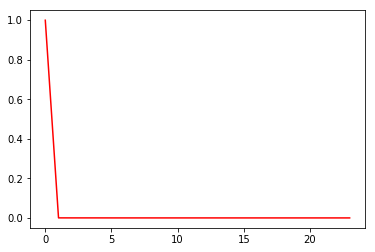

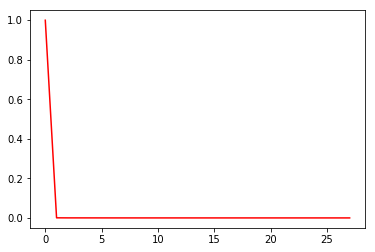

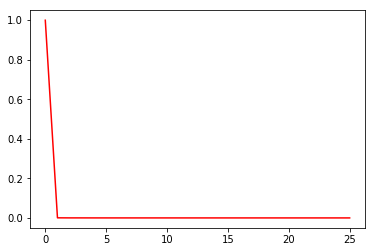

In [8]:
U, s, V = np.linalg.svd(np.cov(advanced_stats.T), full_matrices=False)
plt.plot(range(s.size), np.divide(s, np.sum(s)), 'r-')
plt.show()

U, s, V = np.linalg.svd(np.cov(per_poss_stats.T), full_matrices=False)
plt.plot(range(s.size), np.divide(s, np.sum(s)), 'r-')
plt.show()

U, s, V = np.linalg.svd(np.cov(per_36_stats.T), full_matrices=False)
plt.plot(range(s.size), np.divide(s, np.sum(s)), 'r-')
plt.show()

Most of the variance is explained within the first 2 singular values. We will try 2, 5 dimensions (which is traditional for the NBA), 8, and 10 dimensions.

In [9]:
dimensions = [2, 5, 8, 10]
print("advanced_stats")
for dim in dimensions:
    pca = PCA(n_components=dim)
    pca.fit(advanced_stats)
    print("%d dimensions: %.5f" %(dim, pca.score(advanced_stats)))

print("per_poss_stats")

for dim in dimensions:
    pca = PCA(n_components=dim)
    pca.fit(per_poss_stats)
    print("%d dimensions: %.5f" %(dim, pca.score(per_poss_stats)))
    
print("per_36_stats")

for dim in dimensions:
    pca = PCA(n_components=dim)
    pca.fit(per_36_stats)
    print("%d dimensions: %.5f" %(dim, pca.score(per_36_stats)))

advanced_stats
2 dimensions: -74.12009
5 dimensions: -66.33902
8 dimensions: -59.54342
10 dimensions: -54.94628
per_poss_stats
2 dimensions: -87.16224
5 dimensions: -77.78602
8 dimensions: -67.33648
10 dimensions: -62.30118
per_36_stats
2 dimensions: -75.87046
5 dimensions: -62.28039
8 dimensions: -51.71215
10 dimensions: -46.45283


### Remark
The score reported here is the average log-likelihood of the samples, as used by the ```sklearn``` package. Note that the disparity between PCA in 2 dimensions vs. 10 dimensions is larger for per-36 stats and per-poss stats than advanced stats. From this, I would presume that advanced stats doesn't find as much of a nuanced difference between certain players like per stats, which could be a sign of overfitting for the per stats or a sign of bias in the advanced stats.

Nevertheless, this is just in terms of how the data is reconstructed. To examine some actual results, we need some way of evaluating the new representation.

We'll look at some players that are notable in terms of their playstyle. In terms of player archetype dichotomies, we consider:
    1. LeBron/Giannis/Russell/Wall
    2. Steph/Harden/Isaiah/Paul
    3. Redick/Korver
    4. Jordan/Gortat vs. Davis/Cousins
We'll look at the representation in 2 dimensions because that clustering can be visualized.

In [10]:
player_reps = ["LeBron James", "Giannis Antetokounmpo", "Stephen Curry", "Isaiah Thomas",
               "John Wall", "Chris Paul", "DeAndre Jordan", "Marcin Gortat", "J.J. Redick", "Kyle Korver",
               "Klay Thompson", "Anthony Davis", "DeMarcus Cousins"]

player_indices = [[info[player]['advanced']['index'], info[player]['per_poss']['index'],
                  info[player]['per_36']['index']] for player in player_reps]
rep_info = list(zip(player_reps, player_indices))
print(rep_info)

[('LeBron James', [218, 196, 196]), ('Giannis Antetokounmpo', [15, 14, 14]), ('Stephen Curry', [97, 86, 86]), ('Isaiah Thomas', [422, 381, 381]), ('John Wall', [450, 406, 406]), ('Chris Paul', [349, 316, 316]), ('DeAndre Jordan', [238, 214, 214]), ('Marcin Gortat', [158, 140, 140]), ('J.J. Redick', [370, 334, 334]), ('Kyle Korver', [246, 222, 222]), ('Klay Thompson', [425, 384, 384]), ('Anthony Davis', [99, 88, 88]), ('DeMarcus Cousins', [89, 78, 78])]


In [11]:
def annotate_reps(a_ax, a_data, pp_ax, pp_data, pm_ax, pm_data, rep_info):
    for (name, [a_i, pp_i, pm_i]) in rep_info:
        a_ax.annotate(name, xy=a_data[a_i, :])#, xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        pp_ax.annotate(name, xy=pp_data[pp_i, :])#, xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        pm_ax.annotate(name, xy=pm_data[pm_i, :])#, xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        
def player_plot(advanced_stats, per_poss_stats, per_36_stats):
    f, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize = (15,15))
    axes[0, 0].scatter(advanced_stats[:, 0], advanced_stats[:, 1])
    axes[0, 0].set_title('Advanced Metrics')
    a_spec = np.array([advanced_stats[r[1][0], :] for r in rep_info])
    axes[0, 1].scatter(a_spec[:, 0], a_spec[:, 1])
    axes[0, 1].set_title('Specific Advanced Metrics')
    axes[1, 0].scatter(per_poss_stats[:, 0], per_poss_stats[:, 1])
    axes[1, 0].set_title('Per-possession Metrics')
    pp_spec = np.array([per_poss_stats[r[1][1], :] for r in rep_info])
    axes[1, 1].scatter(pp_spec[:, 0], pp_spec[:, 1])
    axes[1, 1].set_title('Specific Per-possession Metrics')
    axes[2, 0].scatter(per_36_stats[:, 0], per_36_stats[:, 1])
    axes[2, 0].set_title('Per-36 Metrics')
    pm_spec = np.array([per_36_stats[r[1][2], :] for r in rep_info])
    axes[2, 1].scatter(pm_spec[:, 0], pm_spec[:, 1])
    axes[2, 1].set_title('Specific Per-36 Metrics')
    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
    f.subplots_adjust(hspace=0, wspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    annotate_reps(axes[0, 1], advanced_stats, axes[1, 1], per_poss_stats,
                  axes[2, 1], per_36_stats, rep_info)
    plt.show()
    
def closest(advanced_stats, per_poss_stats, per_36_stats, k=5):
    for (name, [a_i, pp_i, pm_i]) in rep_info:
        a_row = advanced_stats[a_i, :]
        pp_row = per_poss_stats[pp_i, :]
        pm_row = per_36_stats[pm_i, :]
        a_mag = [id_player[i] for i in np.argsort(np.linalg.norm(advanced_stats - a_row, axis = 1))[1:k+1]]
        pp_mag = [id_player[i] for i in np.argsort(np.linalg.norm(per_poss_stats - pp_row, axis = 1))[1:k+1]]
        pm_mag = [id_player[i] for i in np.argsort(np.linalg.norm(per_36_stats - pm_row, axis = 1))[1:k+1]]
        print(name)
        print(a_mag)
        print(pp_mag)
        print(pm_mag)

We'll now look at the PCA embeddings of the data with 5, 8, and 13 components. To visualize in two dimensions, we'll use t-SNE to further embed the data into two dimensions in all cases. We'll use t-SNE to do this for every other model later on as well.

In [12]:
pca_advanced_5 = PCA(n_components = 5)
pca_per_poss_5 = PCA(n_components = 5)
pca_per_36_5 = PCA(n_components = 5)

pca_advanced_8 = PCA(n_components = 8)
pca_per_poss_8 = PCA(n_components = 8)
pca_per_36_8 = PCA(n_components = 8)

pca_advanced_13 = PCA(n_components = 13)
pca_per_poss_13 = PCA(n_components = 13)
pca_per_36_13 = PCA(n_components = 13)

pca_advanced_stats_5 = pca_advanced_5.fit_transform(advanced_stats)
pca_per_poss_stats_5 = pca_per_poss_5.fit_transform(per_poss_stats)
pca_per_36_stats_5 = pca_per_36_5.fit_transform(per_36_stats)

pca_advanced_stats_8 = pca_advanced_8.fit_transform(advanced_stats)
pca_per_poss_stats_8 = pca_per_poss_8.fit_transform(per_poss_stats)
pca_per_36_stats_8 = pca_per_36_8.fit_transform(per_36_stats)

pca_advanced_stats_13 = pca_advanced_13.fit_transform(advanced_stats)
pca_per_poss_stats_13 = pca_per_poss_13.fit_transform(per_poss_stats)
pca_per_36_stats_13 = pca_per_36_13.fit_transform(per_36_stats)

Here's the info for PCA down to 5 dimensions.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.005s...
[t-SNE] Computed neighbors for 485 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 16.368739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.531776
[t-SNE] Error after 1000 iterations: 0.174574
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 11.396100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.605968
[t-SNE] Error after 1000 iterations: 0.179955
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 17.965596
[t-SNE] KL divergence after 250 iterations with early

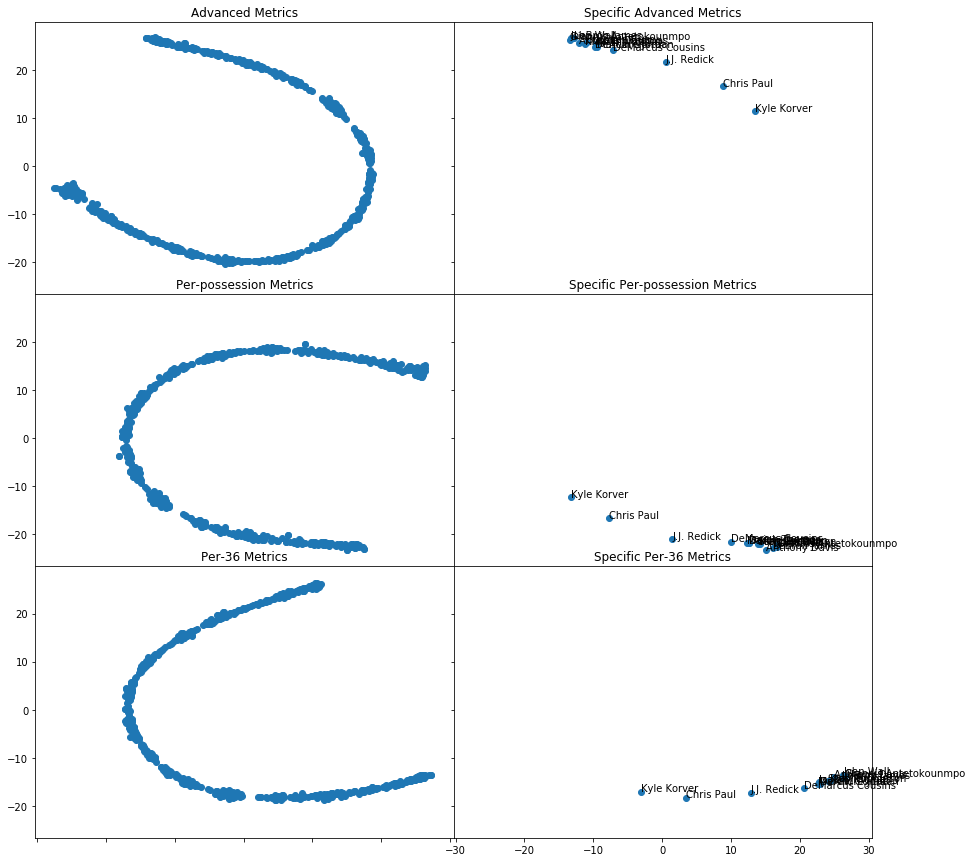

In [13]:
tsne_advanced_5 = TSNE(n_components = 2, verbose = 1)
tsne_per_poss_5 = TSNE(n_components = 2, verbose = 1)
tsne_per_36_5 = TSNE(n_components = 2, verbose = 1)

tsne_advanced_stats_5 = tsne_advanced_5.fit_transform(pca_advanced_stats_5)
tsne_per_poss_stats_5 = tsne_per_poss_5.fit_transform(pca_per_poss_stats_5)
tsne_per_36_stats_5 = tsne_per_36_5.fit_transform(pca_per_36_stats_5)
print(closest(tsne_advanced_stats_5, tsne_per_poss_stats_5, tsne_per_36_stats_5))
player_plot(tsne_advanced_stats_5, tsne_per_poss_stats_5, tsne_per_36_stats_5)

Here's the info for PCA down to 8 dimensions.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.000s...
[t-SNE] Computed neighbors for 485 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 16.395030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.224476
[t-SNE] Error after 1000 iterations: 0.206457
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 12.977887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.841980
[t-SNE] Error after 1000 iterations: 0.189053
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 6.317455
[t-SNE] KL divergence after 250 iterations with early 

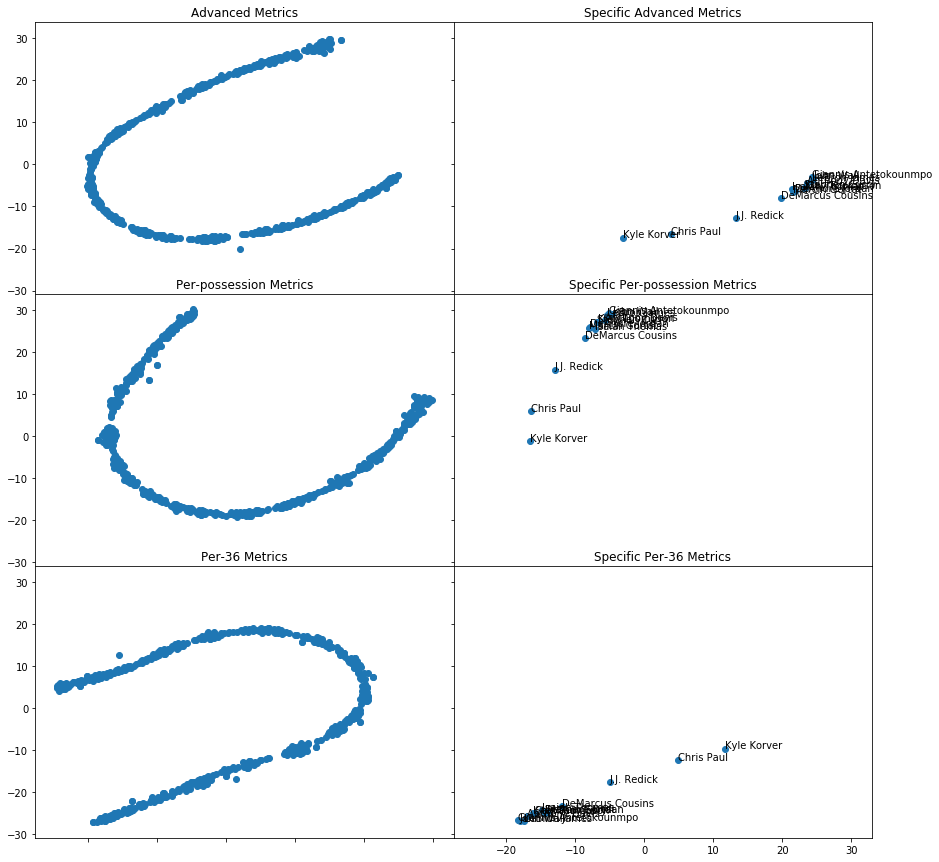

In [14]:
tsne_advanced_8 = TSNE(n_components = 2, verbose = 1)
tsne_per_poss_8 = TSNE(n_components = 2, verbose = 1)
tsne_per_36_8 = TSNE(n_components = 2, verbose = 1)

tsne_advanced_stats_8 = tsne_advanced_8.fit_transform(pca_advanced_stats_8)
tsne_per_poss_stats_8 = tsne_per_poss_8.fit_transform(pca_per_poss_stats_8)
tsne_per_36_stats_8 = tsne_per_36_8.fit_transform(pca_per_36_stats_8)
print(closest(tsne_advanced_stats_8, tsne_per_poss_stats_8, tsne_per_36_stats_8))
player_plot(tsne_advanced_stats_8, tsne_per_poss_stats_8, tsne_per_36_stats_8)

Here's the info for PCA down to 13 dimensions.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.000s...
[t-SNE] Computed neighbors for 485 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 16.371098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.359268
[t-SNE] Error after 1000 iterations: 0.208279
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 32.540864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.462730
[t-SNE] Error after 1000 iterations: 0.205420
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 10.207530
[t-SNE] KL divergence after 250 iterations with early

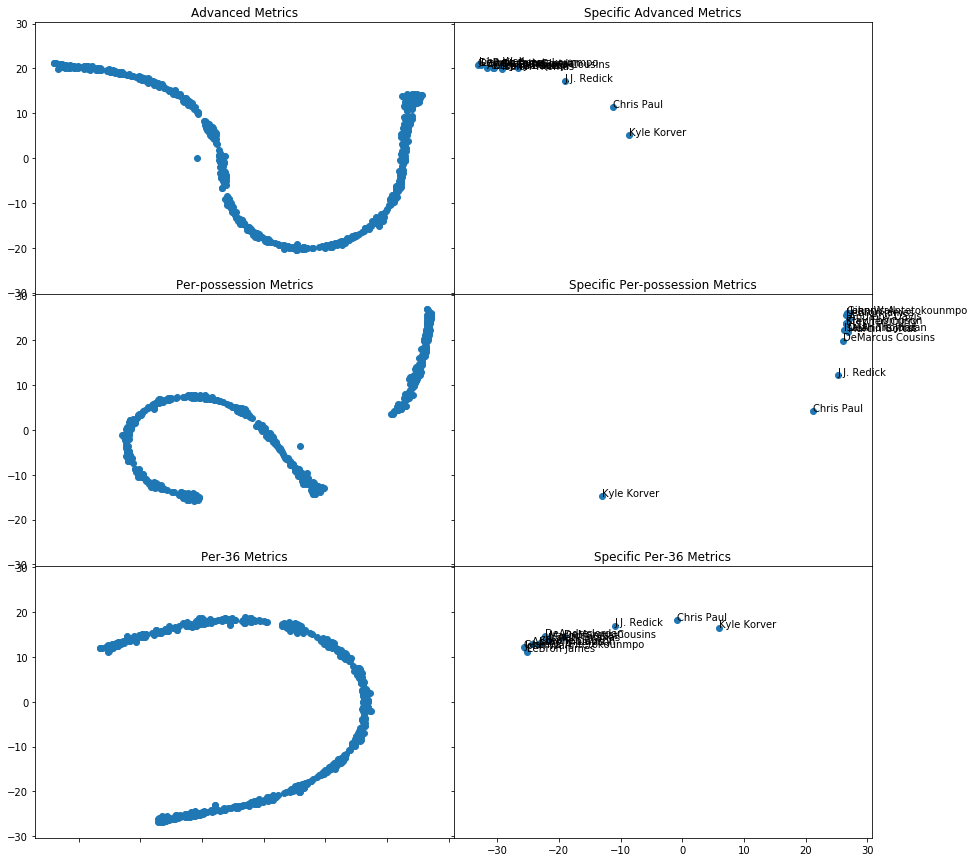

In [15]:
tsne_advanced_13 = TSNE(n_components = 2, verbose = 1)
tsne_per_poss_13 = TSNE(n_components = 2, verbose = 1)
tsne_per_36_13 = TSNE(n_components = 2, verbose = 1)

tsne_advanced_stats_13 = tsne_advanced_13.fit_transform(pca_advanced_stats_13)
tsne_per_poss_stats_13 = tsne_per_poss_13.fit_transform(pca_per_poss_stats_13)
tsne_per_36_stats_13 = tsne_per_36_13.fit_transform(pca_per_36_stats_13)
print(closest(tsne_advanced_stats_13, tsne_per_poss_stats_13, tsne_per_36_stats_13))
player_plot(tsne_advanced_stats_13, tsne_per_poss_stats_13, tsne_per_36_stats_13)

These results don't look very promising. There's only maybe ever 1 or 2 good similar players listed, but the others seem almost randomly selected. Now we'll compare these results with just t-SNE alone, down to two dimensions for visualization.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.001s...
[t-SNE] Computed neighbors for 485 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 11.890389
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.254040
[t-SNE] Error after 1000 iterations: 0.185977
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 13.734823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.694954
[t-SNE] Error after 1000 iterations: 0.210729
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 11.226602
[t-SNE] KL divergence after 250 iterations with early

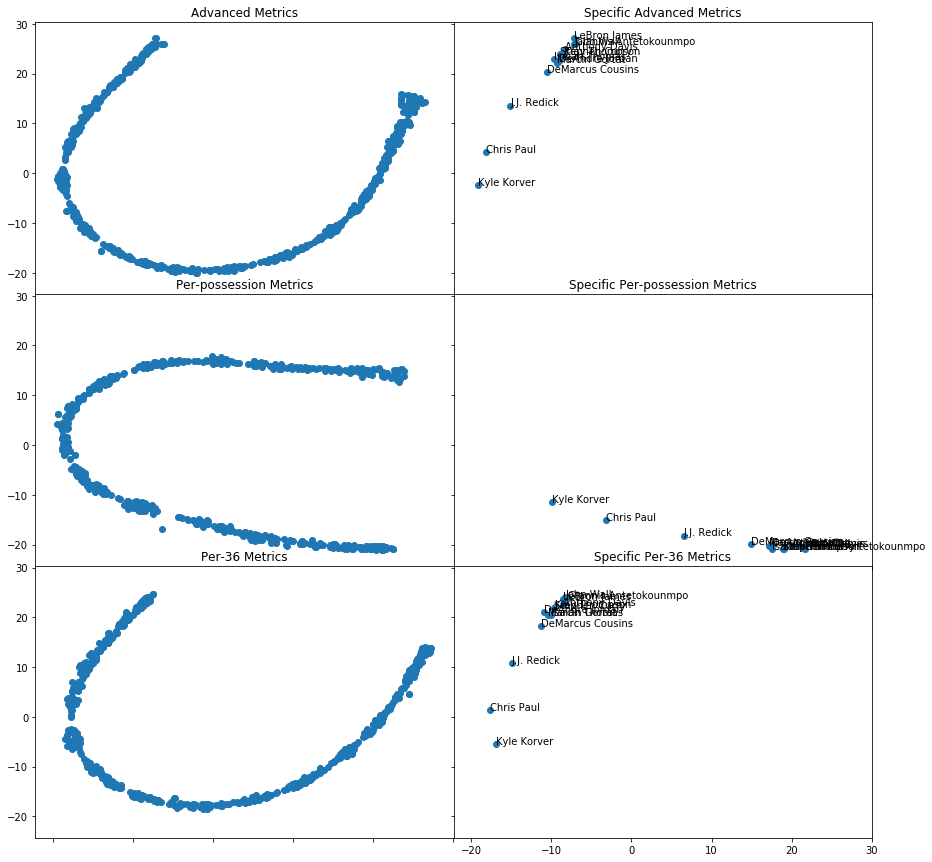

In [16]:
tsne_advanced = TSNE(n_components = 2, verbose = 1)
tsne_per_poss = TSNE(n_components = 2, verbose = 1)
tsne_per_36 = TSNE(n_components = 2, verbose = 1)

tsne_advanced_stats = tsne_advanced.fit_transform(advanced_stats)
tsne_per_poss_stats = tsne_per_poss.fit_transform(per_poss_stats)
tsne_per_36_stats = tsne_per_36.fit_transform(per_36_stats)
print(closest(tsne_advanced_stats, tsne_per_poss_stats, tsne_per_36_stats))
player_plot(tsne_advanced_stats, tsne_per_poss_stats, tsne_per_36_stats)

Looks like PCA just cuts off the information that would pick up on reasonable similarities, but no dimensionality reduction also seems to not be the correct way of analyzing this data, as there's too much redundant information that introduces unneccessary noise.

Now we'll try single-layer autoencoders.

In [17]:
def train(model, train_data, criterion, num_epochs, name=None, verbose=False):
    if (name is not None):
        print("Training %s model now." % name)
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
    train_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        for step, x in enumerate(train_data):
            b_x = Variable(x)   
            b_y = Variable(x)   

            encoded, decoded = model(b_x)

            loss = criterion(decoded, b_y)
            optimizer.zero_grad()
            train_loss += loss.data[0]
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_data))
        if verbose:
            print('Epoch: ', epoch, '| training loss: %.4f' % (train_loss / len(train_data)))
    if (name is not None):
        print("Completed training %s model." % name)
    return train_losses

def single_layer_autoencoder_analysis(advanced_stats, per_poss_stats, per_36_stats, hidden_dim=5,
                                      num_epochs=20, verbose=False, show_losses=False):
    torch_advanced_stats = F.normalize(torch.from_numpy(advanced_stats).type(torch.FloatTensor), p=2, dim=0)
    torch_per_poss_stats = F.normalize(torch.from_numpy(per_poss_stats).type(torch.FloatTensor), p=2, dim=0)
    torch_per_36_stats = F.normalize(torch.from_numpy(per_36_stats).type(torch.FloatTensor), p=2, dim=0)
    
    criterion = nn.MSELoss()

    advanced_model = AutoEncoder(advanced_stats.shape[1], hidden_dim)
    per_poss_model = AutoEncoder(per_poss_stats.shape[1], hidden_dim)    
    per_36_model = AutoEncoder(per_36_stats.shape[1], hidden_dim)

    advanced_train_losses = train(advanced_model, torch_advanced_stats, criterion, num_epochs,
                                  name="advanced", verbose=verbose)
    per_poss_train_losses = train(per_poss_model, torch_per_poss_stats, criterion, num_epochs,
                                  name="per_poss", verbose=verbose)
    per_36_train_losses = train(per_36_model, torch_per_36_stats, criterion, num_epochs,
                                name="per_36", verbose=verbose)

    if (show_losses):
        f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize = (15,15))
        ax1.plot(range(num_epochs), advanced_train_losses)
        ax1.set_title('Advanced Losses')
        ax2.plot(range(num_epochs), per_poss_train_losses)
        ax2.set_title('Per-possession Losses')
        ax3.plot(range(num_epochs), per_36_train_losses)
        ax3.set_title('Per-36 Losses')
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.show()
    
    return advanced_model, per_poss_model, per_36_model

def encode(models, stats, hidden_dim):
    stats = [F.normalize(torch.from_numpy(s).type(torch.FloatTensor), p=2, dim=0) for s in stats]
    encoded_stats = [np.zeros((s.shape[0], hidden_dim)) for s in stats]
    for s, e_s, model in zip(stats, encoded_stats, models):
        for i, x in enumerate(s):
            encoded, _ = model(Variable(x))
            e_s[i, :] = encoded.data.numpy()
    return encoded_stats

Training advanced model now.
Completed training advanced model.
Training per_poss model now.
Completed training per_poss model.
Training per_36 model now.
Completed training per_36 model.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.000s...
[t-SNE] Computed neighbors for 485 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 0.691455
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.646412
[t-SNE] Error after 1000 iterations: 0.168985
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 0.562832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.319504
[t-SNE] Error after 1000 iterations: 0.083404
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed 

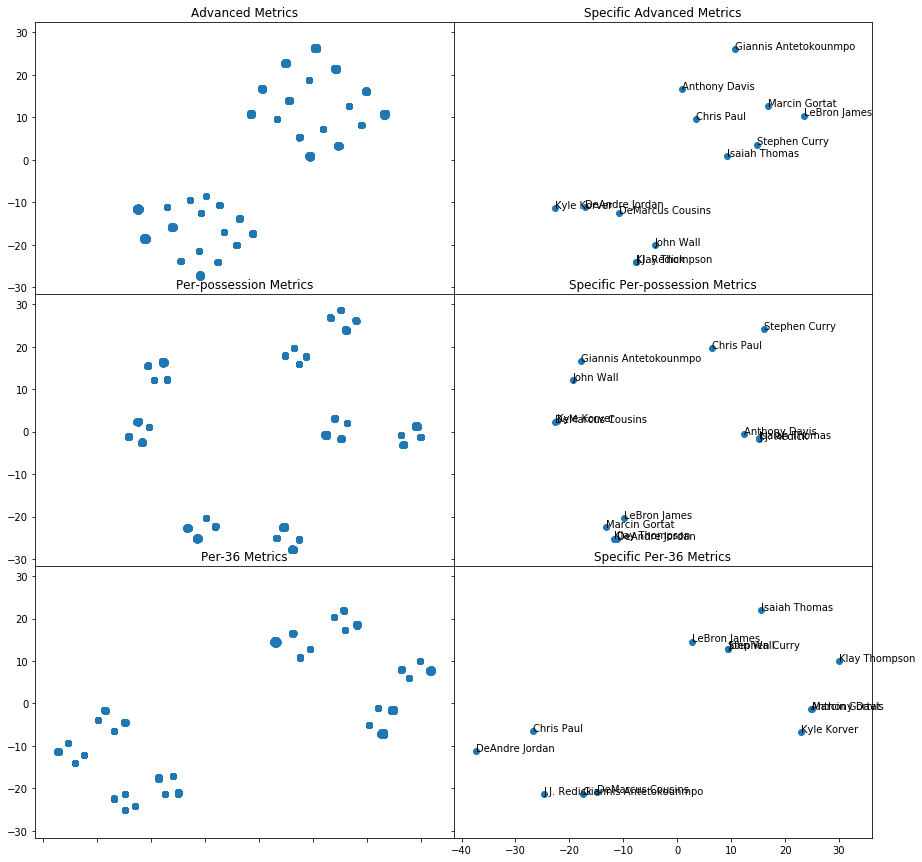

In [18]:
advanced_model, per_poss_model, per_36_model = single_layer_autoencoder_analysis(advanced_stats,
    per_poss_stats, per_36_stats, hidden_dim = 5)

encoded_advanced_stats, encoded_per_poss_stats, encoded_per_36_stats = encode(
    [advanced_model, per_poss_model, per_36_model], [advanced_stats, per_poss_stats, per_36_stats], 5)

tsne_encoded_advanced = TSNE(n_components = 2, verbose = 1)
tsne_encoded_per_poss = TSNE(n_components = 2, verbose = 1)
tsne_encoded_per_36 = TSNE(n_components = 2, verbose = 1)

tsne_encoded_advanced_stats = tsne_encoded_advanced.fit_transform(encoded_advanced_stats)
tsne_encoded_per_poss_stats = tsne_encoded_per_poss.fit_transform(encoded_per_poss_stats)
tsne_encoded_per_36_stats = tsne_encoded_per_36.fit_transform(encoded_per_36_stats)
print(closest(tsne_encoded_advanced_stats, tsne_encoded_per_poss_stats, tsne_encoded_per_36_stats))
player_plot(tsne_encoded_advanced_stats, tsne_encoded_per_poss_stats, tsne_encoded_per_36_stats)

These results are a bit better - we're starting to see 2-4 good comparisons, but still 1-2 players that don't make sense as a means for comparison. Let's now try 8 and 13 for representation sizes.

Training advanced model now.
Completed training advanced model.
Training per_poss model now.
Completed training per_poss model.
Training per_36 model now.
Completed training per_36 model.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.000s...
[t-SNE] Computed neighbors for 485 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 0.773014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.690323
[t-SNE] Error after 1000 iterations: 0.589286
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed neighbors for 439 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 0.716457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.600700
[t-SNE] Error after 1000 iterations: 0.442577
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed 

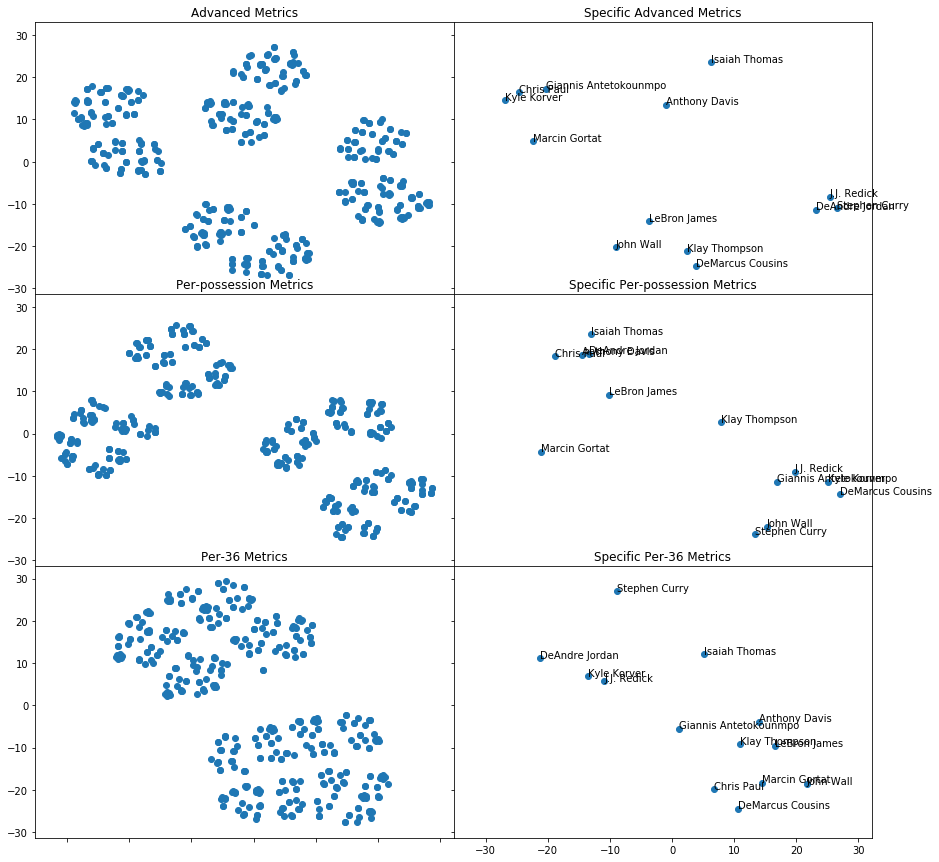

In [19]:
advanced_model, per_poss_model, per_36_model = single_layer_autoencoder_analysis(advanced_stats,
    per_poss_stats, per_36_stats, hidden_dim = 8)

encoded_advanced_stats, encoded_per_poss_stats, encoded_per_36_stats = encode(
    [advanced_model, per_poss_model, per_36_model], [advanced_stats, per_poss_stats, per_36_stats], 8)

tsne_encoded_advanced = TSNE(n_components = 2, verbose = 1)
tsne_encoded_per_poss = TSNE(n_components = 2, verbose = 1)
tsne_encoded_per_36 = TSNE(n_components = 2, verbose = 1)

tsne_encoded_advanced_stats = tsne_encoded_advanced.fit_transform(encoded_advanced_stats)
tsne_encoded_per_poss_stats = tsne_encoded_per_poss.fit_transform(encoded_per_poss_stats)
tsne_encoded_per_36_stats = tsne_encoded_per_36.fit_transform(encoded_per_36_stats)
print(closest(tsne_encoded_advanced_stats, tsne_encoded_per_poss_stats, tsne_encoded_per_36_stats))
player_plot(tsne_encoded_advanced_stats, tsne_encoded_per_poss_stats, tsne_encoded_per_36_stats)

Training advanced model now.
Completed training advanced model.
Training per_poss model now.
Completed training per_poss model.
Training per_36 model now.
Completed training per_36 model.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 485 samples in 0.001s...
[t-SNE] Computed neighbors for 485 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 485 / 485
[t-SNE] Mean sigma: 1.134127
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.929474
[t-SNE] Error after 1000 iterations: 1.007492
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.001s...
[t-SNE] Computed neighbors for 439 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 439 / 439
[t-SNE] Mean sigma: 0.995709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.182083
[t-SNE] Error after 1000 iterations: 0.741534
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 439 samples in 0.000s...
[t-SNE] Computed 

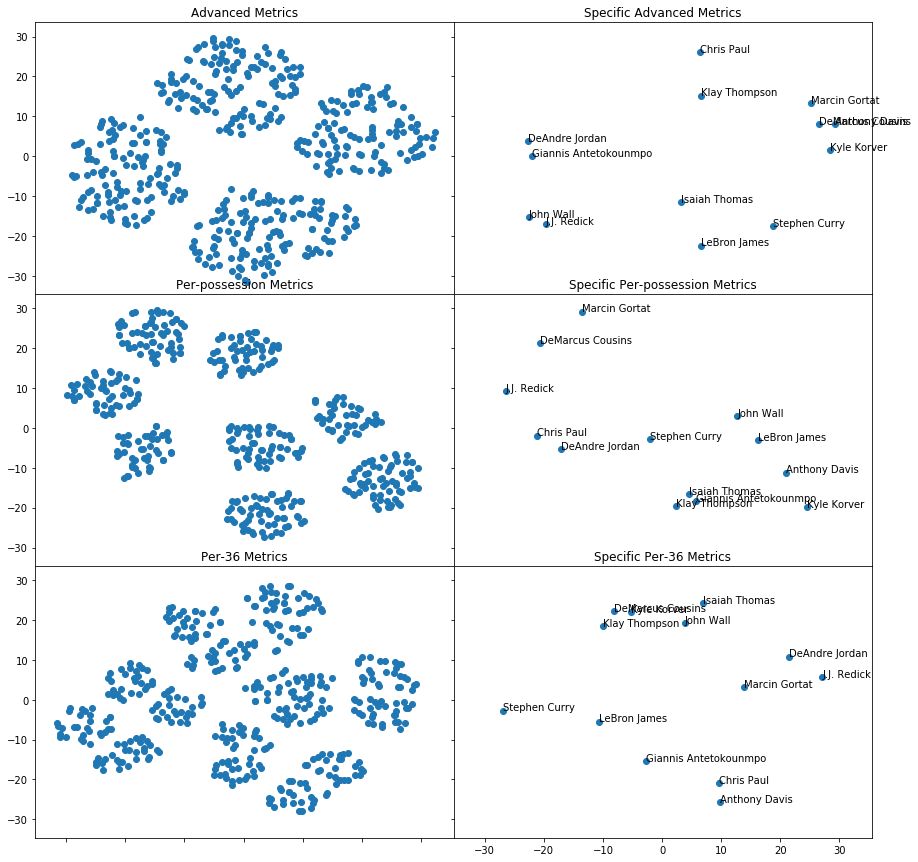

In [20]:
advanced_model, per_poss_model, per_36_model = single_layer_autoencoder_analysis(advanced_stats,
    per_poss_stats, per_36_stats, hidden_dim = 13)

encoded_advanced_stats, encoded_per_poss_stats, encoded_per_36_stats = encode(
    [advanced_model, per_poss_model, per_36_model], [advanced_stats, per_poss_stats, per_36_stats], 13)

tsne_encoded_advanced = TSNE(n_components = 2, verbose = 1)
tsne_encoded_per_poss = TSNE(n_components = 2, verbose = 1)
tsne_encoded_per_36 = TSNE(n_components = 2, verbose = 1)

tsne_encoded_advanced_stats = tsne_encoded_advanced.fit_transform(encoded_advanced_stats)
tsne_encoded_per_poss_stats = tsne_encoded_per_poss.fit_transform(encoded_per_poss_stats)
tsne_encoded_per_36_stats = tsne_encoded_per_36.fit_transform(encoded_per_36_stats)
print(closest(tsne_encoded_advanced_stats, tsne_encoded_per_poss_stats, tsne_encoded_per_36_stats))
player_plot(tsne_encoded_advanced_stats, tsne_encoded_per_poss_stats, tsne_encoded_per_36_stats)

Adding larger representation sizes seems to remove the larger separation from smaller representations, which is opposite of what Alagappan found in his study. This is a bit odd - it would be more reasonable that, when adding more dimensions to the representation, larger variance is exhibited, leading to more separation in the t-SNE run. Moreover, it seems like the comparisons get worse for point guards and point forwards, but is relatively the same quality for big men.

### Multilayer Autoencoder Analysis

Now we'll try using multiple layers and see if the extra non-linear activations fits the manifold more closely.

In [21]:
def multilayer_autoencoder_analysis(advanced_stats, per_poss_stats, per_36_stats, hidden_layer_dims, hidden_dim=5,
                                      num_epochs=20, verbose=False, show_losses=False):
    torch_advanced_stats = F.normalize(torch.from_numpy(advanced_stats).type(torch.FloatTensor), p=2, dim=0)
    torch_per_poss_stats = F.normalize(torch.from_numpy(per_poss_stats).type(torch.FloatTensor), p=2, dim=0)
    torch_per_36_stats = F.normalize(torch.from_numpy(per_36_stats).type(torch.FloatTensor), p=2, dim=0)
    
    criterion = nn.MSELoss()

    advanced_model = MultilayerAutoEncoder(advanced_stats.shape[1], hidden_dim, hidden_layer_dims)
    per_poss_model = MultilayerAutoEncoder(per_poss_stats.shape[1], hidden_dim, hidden_layer_dims)    
    per_36_model = MultilayerAutoEncoder(per_36_stats.shape[1], hidden_dim, hidden_layer_dims)

    advanced_train_losses = train(advanced_model, torch_advanced_stats, criterion,
                                  num_epochs, name="advanced", verbose=verbose)
    per_poss_train_losses = train(per_poss_model, torch_per_poss_stats, criterion,
                                  num_epochs, name="per_poss", verbose=verbose)
    per_36_train_losses = train(per_36_model, torch_per_36_stats, criterion,
                                num_epochs, name="per_36", verbose=verbose)

    if (show_losses):
        f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize = (15,15))
        ax1.plot(range(num_epochs), advanced_train_losses)
        ax1.set_title('Advanced Losses')
        ax2.plot(range(num_epochs), per_poss_train_losses)
        ax2.set_title('Per-possession Losses')
        ax3.plot(range(num_epochs), per_36_train_losses)
        ax3.set_title('Per-36 Losses')
        f.subplots_adjust(hspace=0)
        plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
        plt.show()
    
    return advanced_model, per_poss_model, per_36_model

Training advanced model now.
Epoch:  0 | training loss: 0.0058
Epoch:  1 | training loss: 0.0022
Epoch:  2 | training loss: 0.0022
Epoch:  3 | training loss: 0.0020
Epoch:  4 | training loss: 0.0021
Epoch:  5 | training loss: 0.0019
Epoch:  6 | training loss: 0.0020
Epoch:  7 | training loss: 0.0021
Epoch:  8 | training loss: 0.0021
Epoch:  9 | training loss: 0.0021
Epoch:  10 | training loss: 0.0022
Epoch:  11 | training loss: 0.0021
Epoch:  12 | training loss: 0.0022
Epoch:  13 | training loss: 0.0021
Epoch:  14 | training loss: 0.0022
Epoch:  15 | training loss: 0.0022
Epoch:  16 | training loss: 0.0022
Epoch:  17 | training loss: 0.0022
Epoch:  18 | training loss: 0.0022
Epoch:  19 | training loss: 0.0022
Completed training advanced model.
Training per_poss model now.
Epoch:  0 | training loss: 0.0066
Epoch:  1 | training loss: 0.0022
Epoch:  2 | training loss: 0.0022
Epoch:  3 | training loss: 0.0021
Epoch:  4 | training loss: 0.0020
Epoch:  5 | training loss: 0.0020
Epoch:  6 | t

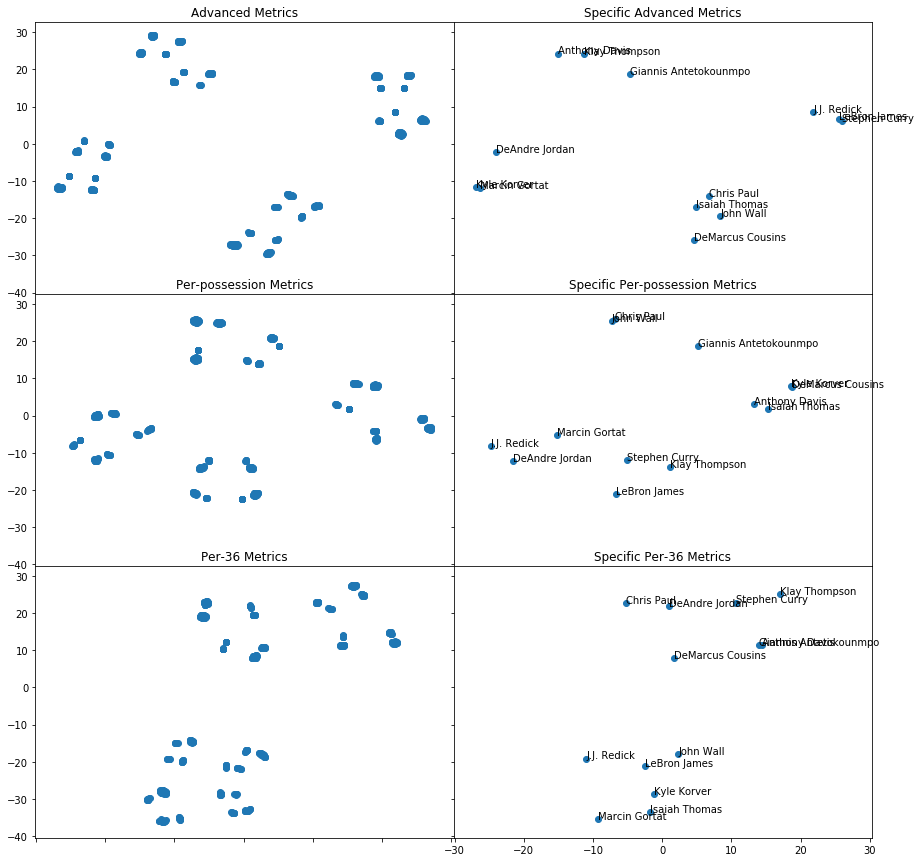

In [22]:
multi_advanced_model, multi_per_poss_model, multi_per_36_model = multilayer_autoencoder_analysis(advanced_stats,
    per_poss_stats, per_36_stats, [13, 8], verbose=True)

multi_encoded_advanced_stats, multi_encoded_per_poss_stats, multi_encoded_per_36_stats = encode(
    [multi_advanced_model, multi_per_poss_model, multi_per_36_model],
    [advanced_stats, per_poss_stats, per_36_stats], 5)

tsne_multi_encoded_advanced = TSNE(n_components = 2, verbose = 1)
tsne_multi_encoded_per_poss = TSNE(n_components = 2, verbose = 1)
tsne_multi_encoded_per_36 = TSNE(n_components = 2, verbose = 1)

tsne_multi_encoded_advanced_stats = tsne_multi_encoded_advanced.fit_transform(multi_encoded_advanced_stats)
tsne_multi_encoded_per_poss_stats = tsne_multi_encoded_per_poss.fit_transform(multi_encoded_per_poss_stats)
tsne_multi_encoded_per_36_stats = tsne_multi_encoded_per_36.fit_transform(multi_encoded_per_36_stats)
print(closest(tsne_multi_encoded_advanced_stats, tsne_multi_encoded_per_poss_stats, tsne_multi_encoded_per_36_stats))
player_plot(tsne_multi_encoded_advanced_stats, tsne_multi_encoded_per_poss_stats, tsne_multi_encoded_per_36_stats)

This now seems to favor better quality for smaller players, and even the ball dominant smaller players, but loses quality for the big men. Still, at this point, we've never gotten 5 good comparisons, which seems to be an indication that the characteristic roles here are probably linearly separable, just not in the standard choices of directions of variance, as we saw with the performance of PCA.

### Conclusions
- non-linearity doesn't seem to help very much
    - linear separation of the function space seems ideal still, but PCA doesn't uncover this very well
- things that could have improved performance
    - stricter loss function
    - finer-tuned validation
    - more player data (from previous years, separating on years)